## Package Installation

In [ ]:
%pip install -r requirements.txt

In [34]:
from models.sam import SamPredictor, sam_model_registry
from models.sam.modeling.prompt_encoder import attention_fusion
import numpy as np
import os
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from dsc import dice_coeff
import torchio as tio
import nrrd
import PIL
import cfg
from funcs import *
from predict_funs import *
args = cfg.parse_args()
from monai.networks.nets import VNet
args.if_mask_decoder_adapter=True
args.if_encoder_adapter = True
args.decoder_adapt_depth = 2
%matplotlib inline

## Load models

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
checkpoint_directory = './' # path to your checkpoint
img_folder = os.path.join('images')
gt_msk_folder = os.path.join('masks')
predicted_msk_folder = os.path.join('predicted_masks')
cls = 1

sam_fine_tune = sam_model_registry["vit_t"](args,checkpoint=os.path.join('mobile_sam.pt'),num_classes=2)
sam_fine_tune.attention_fusion = attention_fusion()  
sam_fine_tune.load_state_dict(torch.load(os.path.join(checkpoint_directory,'bone_sam.pth'),map_location=torch.device(device)), strict = True)
sam_fine_tune = sam_fine_tune.to(device).eval()

vnet = VNet().to(device)
model_directory = "./"
vnet.load_state_dict(torch.load(os.path.join(model_directory,'atten.pth'),map_location=torch.device(device)))

cpu


<All keys matched successfully>

## 2D Slice Prediction & Evaluation

In [3]:
def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    voxels, header = nrrd.read(os.path.join(gt_msk_folder,mask_name))
    mask_gt = voxels

    msk = Image.fromarray(mask_gt[:,:,slice_id].astype(np.uint8), 'L')
    msk = transforms.Resize((256,256))(msk)
    msk_gt = (transforms.ToTensor()(msk)>0).float()

    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    
    image1_vol = tio.ScalarImage(os.path.join(img_folder, image_name))
    print('vol shape: %s vol spacing %s' %(image1_vol.shape,image1_vol.spacing))

    image_tensor = image1_vol.data
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)

    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)

    # Normalize the data to [0, 1] 
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)

    image1_vol.set_data(image_tensor)
    atten_map= pred_attention(image1_vol,vnet,slice_id,device)
    
    atten_map = torch.unsqueeze(torch.tensor(atten_map),0).float().to(device)
    print(atten_map.device)
    if attention_enabled:
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=slice_id,atten_map=atten_map)
    else:
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=slice_id)
        
    mask_pred = ((pred_1>0)==cls).float().cpu()

    return ori_img, mask_pred, atten_map

def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt):
    image = np.rot90(torchvision.transforms.Resize((args.out_size,args.out_size))(ori_img)[0])
    image_3d = np.repeat(np.array(image*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)

    pred_mask_auto = (mask_pred[0])*255
    mask = (msk_gt.cpu()[0]>0)*255

    target_prediction =  [103,169,237]   
    image_pred_auto = drawContour(image_3d.copy(), np.rot90(pred_mask_auto),target_prediction,size=-1,a=0.6)

    target_prediction =  [100,255,106] 
    image_mask = drawContour(image_3d.copy(),np.rot90(mask),target_prediction,size=-1,a=0.6)

    fig, a = plt.subplots(1,4, figsize=(20,15))
    a[0].imshow(image,cmap='gray',vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)

    a[1].imshow(image_mask,cmap='gray',vmin=0, vmax=255)
    a[1].set_title('gt_mask',fontsize=10)
    a[1].axis(False)

    a[2].imshow(image_pred_auto,cmap='gray',vmin=0, vmax=255)
    a[2].set_title('pre_mask_auto, dsc %.2f'%(dsc_gt),fontsize=10)
    a[2].axis(False)

    a[3].imshow(np.rot90(atten_map.cpu()[0]),vmin=0, vmax=1,cmap='coolwarm')
    a[3].set_title('atten_map',fontsize=10)
    a[3].axis(False)

    plt.tight_layout()

In [ ]:
ori_img, predictedSliceMask, atten_map = predictSlice(
    image_name = '2.nii.gz', 
    lower_percentile = 1,
    upper_percentile = 99,
    slice_id = 50, # slice number
    attention_enabled = True, # if you want to use the depth attention
)

msk_gt, dsc_gt = evaluateSlicePrediction(
    mask_pred = predictedSliceMask, 
    mask_name = '2.nrrd', 
    slice_id = 50
)

visualizeSlicePrediction(
    ori_img=ori_img, 
    image_name='2.nii.gz', 
    atten_map=atten_map, 
    msk_gt=msk_gt, 
    mask_pred=predictedSliceMask, 
    dsc_gt=dsc_gt
)

dsc_gt: 0.42505884170532227


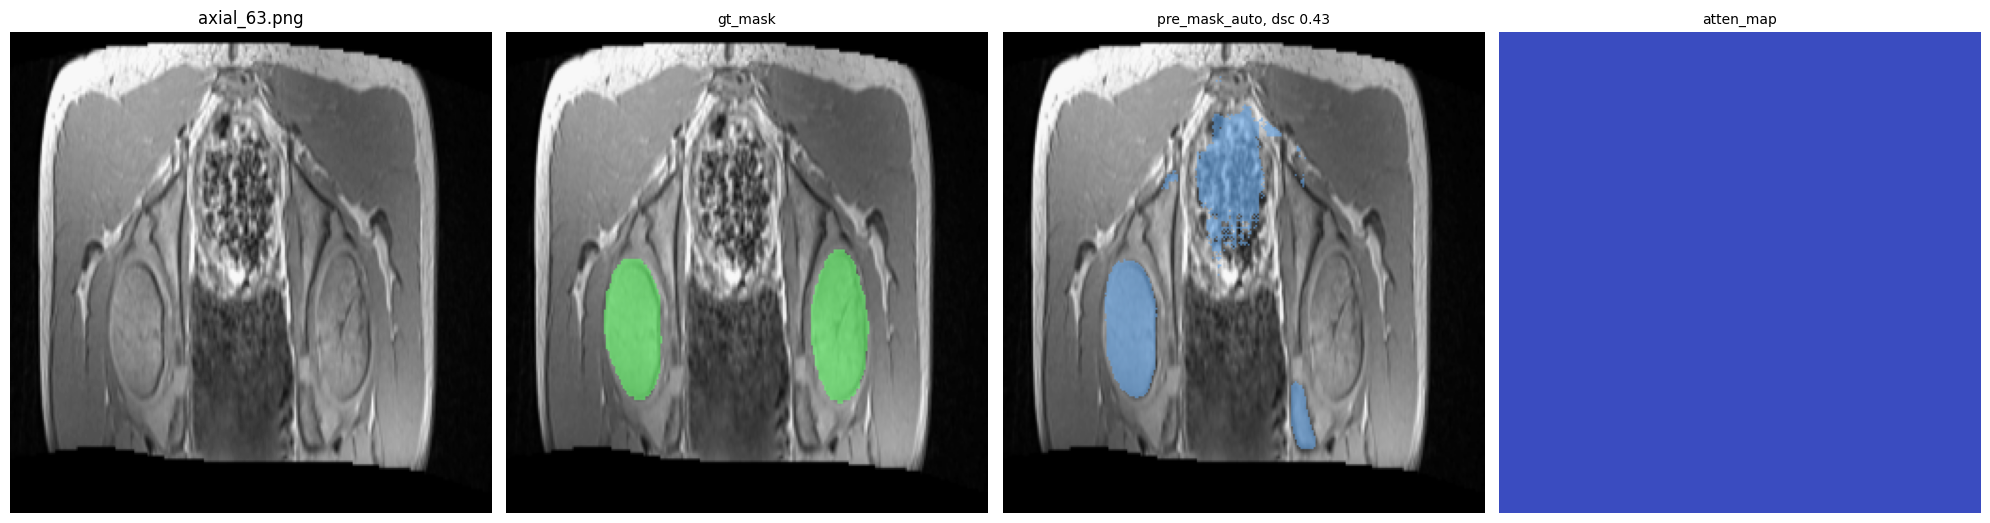

In [14]:
def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    # Read corresponding PNG mask
    msk = Image.open(os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png"))  # Assume mask filename format is "name_sliceid.png"
    msk = transforms.Resize((256,256))(msk)
    # Convert RGB image to grayscale if needed
    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk)>0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    # Read PNG image
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to tensor and adjust dimensions
    image_tensor = transforms.ToTensor()(image)  # [1, H, W]
    
    # Adjust dimensions to [1, 1, H, W, 1] (channels, x, y, z)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension [1, 1, H, W]
    image_tensor = image_tensor.unsqueeze(-1)  # Add z dimension [1, 1, H, W, 1]
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Rearrange dimensions to (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
    
    # Create torchio ScalarImage object
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    atten_map = pred_attention(image1_vol, vnet, 0, device)  # slice_id set to 0 as we only have one slice
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)
    
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map)
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0)
    
    mask_pred = ((pred_1>0)==cls).float().cpu()
    return ori_img, mask_pred, atten_map

def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt):
    # Resize without rotation
    image = torchvision.transforms.Resize((args.out_size,args.out_size))(ori_img)[0]
    image_3d = np.repeat(np.array(image*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)
    
    # Process mask without rotation
    pred_mask_auto = (mask_pred[0])*255
    mask = (msk_gt.cpu()[0]>0)*255
    
    # Draw contours without rotation
    target_prediction = [103,169,237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100,255,106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    # Display images
    fig, a = plt.subplots(1,4, figsize=(20,15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('gt_mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('pre_mask_auto, dsc %.2f'%(dsc_gt), fontsize=10)
    a[2].axis(False)
    
    # Display attention map without rotation
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('atten_map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

# Usage example
ori_img, predictedSliceMask, atten_map = predictSlice(
    image_name = 'axial',  # Base image name, without slice_id
    lower_percentile = 1,
    upper_percentile = 99,
    slice_id = 63,  # Slice number
    attention_enabled = True
)

msk_gt, dsc_gt = evaluateSlicePrediction(
    mask_pred = predictedSliceMask,
    mask_name = 'axial',  # Base mask name, without slice_id
    slice_id = 63
)

# visualizeSlicePrediction function remains unchanged
visualizeSlicePrediction(
    ori_img=ori_img,
    image_name='axial_63.png',
    atten_map=atten_map,
    msk_gt=msk_gt,
    mask_pred=predictedSliceMask,
    dsc_gt=dsc_gt
)

In [68]:
def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    # Read corresponding PNG mask
    msk = Image.open(os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png"))  # Assume mask filename format is "name_sliceid.png"
    msk = transforms.Resize((256,256))(msk)
    # Convert RGB image to grayscale if needed
    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk)>0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt

def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled):
    # Read PNG image
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert to tensor and adjust dimensions
    image_tensor = transforms.ToTensor()(image)  # [1, H, W]
    
    # Adjust dimensions to [1, 1, H, W, 1] (channels, x, y, z)
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension [1, 1, H, W]
    image_tensor = image_tensor.unsqueeze(-1)  # Add z dimension [1, 1, H, W, 1]
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Rearrange dimensions to (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)  # Remove batch dimension
    
    # Create torchio ScalarImage object
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    atten_map = pred_attention(image1_vol, vnet, 0, device)  # slice_id set to 0 as we only have one slice
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)
    
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map)
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattention(
            image1_vol, sam_fine_tune, device, slice_id=0)
    
    mask_pred = ((pred_1>0)==cls).float().cpu()
    return ori_img, mask_pred, atten_map

def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt):
    # Resize without rotation
    image = torchvision.transforms.Resize((args.out_size,args.out_size))(ori_img)[0]
    image_3d = np.repeat(np.array(image*255,dtype=np.uint8).copy()[:, :, np.newaxis], 3, axis=2)
    
    # Process mask without rotation
    pred_mask_auto = (mask_pred[0])*255
    mask = (msk_gt.cpu()[0]>0)*255
    
    # Draw contours without rotation
    target_prediction = [103,169,237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100,255,106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    # Display images
    fig, a = plt.subplots(1,4, figsize=(20,15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('gt_mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('pre_mask_auto, dsc %.2f'%(dsc_gt), fontsize=10)
    a[2].axis(False)
    
    # Display attention map without rotation
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('atten_map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

def save_segment_results(image_list, mask_list, output_folder, lower_percentile, upper_percentile, attention_enabled):
    """
    Test and save segmentation results for a list of images.

    Args:
        image_list (list): List of image file paths.
        mask_list (list): List of mask file paths corresponding to the images.
        output_folder (str): Folder to save the segmentation results.
        lower_percentile (int): Lower percentile for normalization.
        upper_percentile (int): Upper percentile for normalization.
        attention_enabled (bool): Whether to use the attention map.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for image_path, mask_path in zip(image_list, mask_list):
        # Extract slice ID from filename
        slice_id = os.path.basename(image_path).split('_')[-1].split('.')[0]

        # Extract base names for image and mask
        image_base_name = '_'.join(os.path.basename(image_path).split('_')[:5])  # E.g., "TD09_S1_MRI_axial"
        mask_base_name = '_'.join(os.path.basename(mask_path).split('_')[:6])   # E.g., "TD09_S1_L_femur-label_axial"

        # Perform prediction
        ori_img, predictedSliceMask, atten_map = predictSlice(
            image_name=image_base_name,
            lower_percentile=lower_percentile,
            upper_percentile=upper_percentile,
            slice_id=slice_id,
            attention_enabled=attention_enabled
        )

        # Evaluate prediction
        msk_gt, dsc_gt = evaluateSlicePrediction(
            mask_pred=predictedSliceMask,
            mask_name=mask_base_name,
            slice_id=slice_id
        )

        # Save segmentation result
        output_file = os.path.join(output_folder, f"segmented_{os.path.basename(image_path)}")
        segmented_image = (predictedSliceMask[0].cpu().numpy() * 255).astype('uint8')  # Convert to uint8 for saving
        Image.fromarray(segmented_image).save(output_file)

        print(f"Saved segmented result to {output_file} (DSC: {dsc_gt:.4f})")

# Test images and masks
test_images = [
    "TD09_S1_MRI_axial_origin_041.png",
    "TD09_S1_MRI_axial_origin_392.png",
    "TD09_S1_MRI_axial_origin_511.png"
]
test_masks = [
    "TD09_S1_L_femur-label_axial_mask_041.png",
    "TD09_S1_L_femur-label_axial_mask_392.png",
    "TD09_S1_L_femur-label_axial_mask_511.png"
]
output_dir = "./segmentation_results"

# Run the test and save results
save_segment_results(test_images, test_masks, output_dir, lower_percentile=1, upper_percentile=99, attention_enabled=True)



dsc_gt: 0.8159509301185608
Saved segmented result to ./segmentation_results/segmented_TD09_S1_MRI_axial_origin_041.png (DSC: 0.8160)
dsc_gt: 0.9162701964378357
Saved segmented result to ./segmentation_results/segmented_TD09_S1_MRI_axial_origin_392.png (DSC: 0.9163)
dsc_gt: 0.542868435382843
Saved segmented result to ./segmentation_results/segmented_TD09_S1_MRI_axial_origin_511.png (DSC: 0.5429)


Selected points: [(95, 95), (248, 94)]


/var/folders/9_/k4h2cghj2s3bg4nf0hlx69p40000gn/T/ipykernel_97527/3410318576.py:47: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)


dsc_gt: 0.41545894742012024


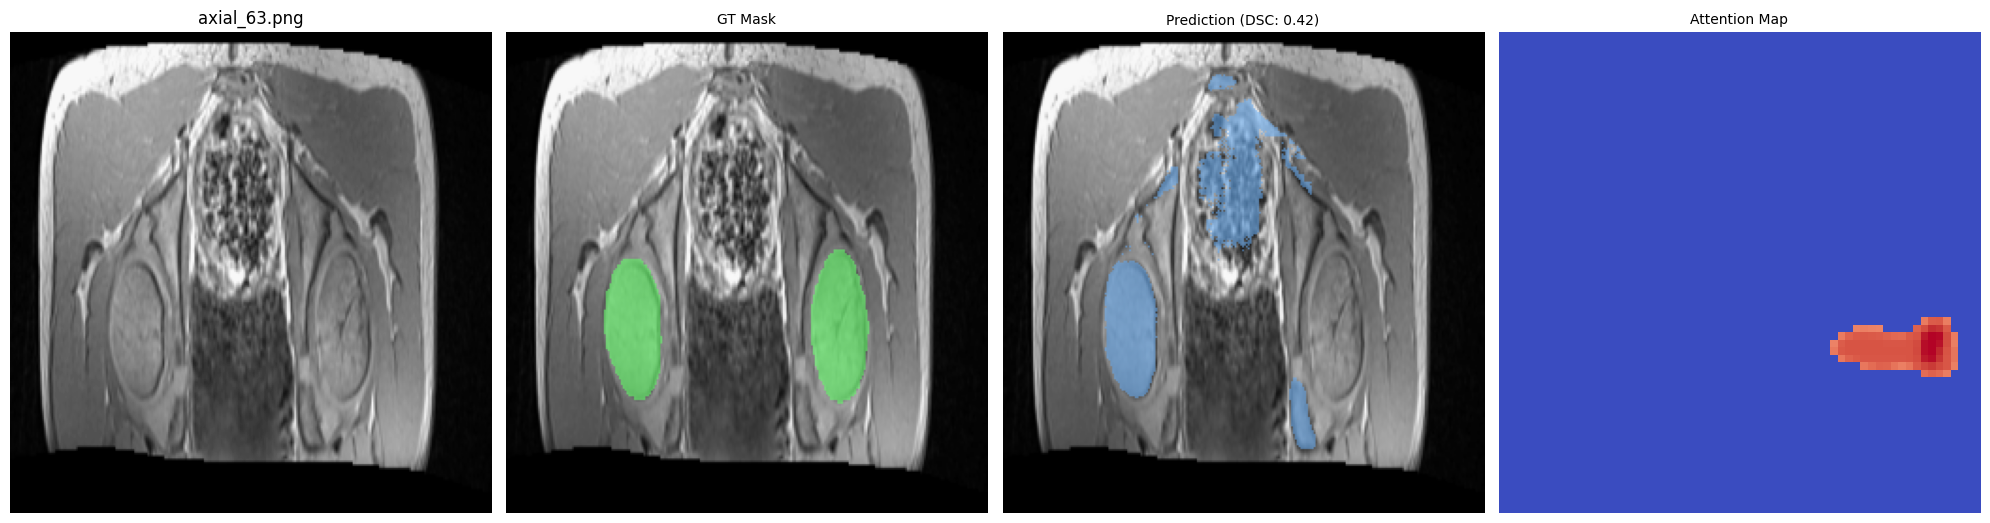

In [70]:
# Global variables for mouse callback
drawing_points = []

# Mouse callback function to capture points
def select_points(event, x, y, flags, param):
    global drawing_points
    if event == cv2.EVENT_LBUTTONDOWN:
        # Append the clicked point to the list
        drawing_points.append((x, y))
        # Draw a small circle at the clicked point
        cv2.circle(temp_img, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
        cv2.imshow('Select Points', temp_img)

# Function to manually select points on an image
def get_selected_points(image_path):
    global temp_img

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Cannot find or open image: {image_path}")

    # Create a copy of the image for drawing
    temp_img = img.copy()

    # Display the image and set up mouse callback
    cv2.namedWindow('Select Points')
    cv2.setMouseCallback('Select Points', select_points)

    while True:
        cv2.imshow('Select Points', temp_img)
        key = cv2.waitKey(1) & 0xFF

        # Press 'q' to finish point selection
        if key == ord('q'):
            break

    cv2.destroyAllWindows()
    cv2.waitKey(1)
    return drawing_points

def evaluate_1_volume_withattentionpoints(image_vol, model, device, slice_id=None, target_spacing=None, atten_map=None, selected_points=None):
    """
    Evaluate a single volume slice with optional attention map and selected points (prompts).
    """
    # Normalize volume data
    image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)
    voxel_spacing = image_vol.spacing
    
    # Resample if target_spacing is provided
    if target_spacing and (voxel_spacing != target_spacing):
        resample = tio.Resample(target_spacing, image_interpolation='nearest')
        image_vol = resample(image_vol)
    
    # Get the slice
    image_vol = image_vol.data[0]
    slice_num = image_vol.shape[2]
    if slice_id is not None:
        if slice_id > slice_num:
            slice_id = -1
    else:
        slice_id = slice_num // 2
    
    # Convert slice data to [0, 255] range
    img_arr = image_vol[:, :, slice_id]
    img_arr = np.array((img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 0.00001) * 255, dtype=np.uint8)
    
    # Convert single channel to RGB
    img_3c = np.tile(img_arr[:, :, None], [1, 1, 3])
    img = Image.fromarray(img_3c, 'RGB')
    Pil_img = img.copy()
    img = transforms.Resize((1024, 1024))(img)
    
    # Transform and normalize
    transform_img = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform_img(img)
    img = min_max_normalize(img)
    if img.mean() < 0.1:
        img = monai.transforms.AdjustContrast(gamma=0.8)(img)
    
    imgs = torch.unsqueeze(
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), 0
    ).to(device)

    # Forward pass with optional attention and selected points (prompts)
    with torch.no_grad():
        img_emb = model.image_encoder(imgs)
        
        if selected_points is not None:
            sparse_emb, dense_emb = model.prompt_encoder(points=selected_points, boxes=None, masks=None)
        else:
            sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=None, masks=None)
        
        if atten_map is not None:
            img_emb = model.attention_fusion(img_emb, atten_map)
        
        pred, _ = model.mask_decoder(
            image_embeddings=img_emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
        )
        pred = pred[:, 1, :, :]
    ori_img = inverse_normalize(imgs.cpu()[0])
    
    return ori_img, pred, voxel_spacing, Pil_img, slice_id


def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    """
    Compute Dice Coefficient (DSC) between prediction and ground truth mask.
    """
    mask_path = os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png")
    msk = Image.open(mask_path)
    msk = transforms.Resize((256, 256))(msk)

    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk) > 0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt


def predictSlice_points(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled, selected_points=None):
    """
    Predict the mask for a single slice, optionally using an attention map and/or selected points (prompts).
    """
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert image to tensor
    image_tensor = transforms.ToTensor()(image)
    
    # Adjust dimensions to [1, 1, H, W, 1]
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.unsqueeze(-1)
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Remove batch dimension -> (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    # Generate attention map
    atten_map = pred_attention(image1_vol, vnet, 0, device)
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)

    # Evaluate using attention map or just points
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionpoints(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map, selected_points=selected_points
        )
    else:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionpoints(
            image1_vol, sam_fine_tune, device, slice_id=0, selected_points=selected_points
        )
    
    mask_pred = ((pred_1 > 0) == cls).float().cpu()
    return ori_img, mask_pred, atten_map


def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt, selected_points=None):
    """
    Visualize original image, ground truth mask, predicted mask, and attention map.
    Optionally, display selected points on the image.
    """
    image = torchvision.transforms.Resize((args.out_size, args.out_size))(ori_img)[0]
    image_3d = np.repeat((image * 255).numpy().astype(np.uint8)[:, :, np.newaxis], 3, axis=2)
    
    pred_mask_auto = (mask_pred[0]) * 255
    mask = (msk_gt.cpu()[0] > 0) * 255
    
    target_prediction = [103, 169, 237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100, 255, 106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    if selected_points is not None:
        # Draw selected points
        for point in selected_points:
            image_3d = cv2.circle(image_3d, point, radius=5, color=(255, 0, 0), thickness=3)
    
    fig, a = plt.subplots(1, 4, figsize=(20, 15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('GT Mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('Prediction (DSC: %.2f)' % dsc_gt, fontsize=10)
    a[2].axis(False)
    
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('Attention Map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()

# Updated main workflow
image_path = "./images/axial_63.png"  # Replace with your image path
points = get_selected_points(image_path)
print("Selected points:", points)

# Convert points to torch tensors for the SAM model
coords = torch.tensor([points], dtype=torch.float32)  # Shape: (1, N, 2)
labels = torch.tensor([[1] * len(points)], dtype=torch.int)  # Assume all points are foreground (label = 1)
selected_points = (coords, labels)

# Example usage of selected points
ori_img, predictedSliceMask, atten_map = predictSlice_points(
    image_name='axial',
    lower_percentile=1,
    upper_percentile=99,
    slice_id=63,
    attention_enabled=True,
    selected_points=selected_points
)

# Evaluate prediction
msk_gt, dsc_gt = evaluateSlicePrediction(
    mask_pred=predictedSliceMask,
    mask_name='axial',
    slice_id=63
)

# Visualize results
visualizeSlicePrediction(
    ori_img=ori_img,
    image_name='axial_63.png',
    atten_map=atten_map,
    msk_gt=msk_gt,
    mask_pred=predictedSliceMask,
    dsc_gt=dsc_gt,
    selected_points=points
)



In [60]:
import cv2

# Global variables
drawing = False
x1, y1 = -1, -1
x2, y2 = -1, -1

def draw_box(event, x, y, flags, param):
    global drawing, x1, y1, x2, y2, img, temp_img

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x1, y1 = x, y
        x2, y2 = x, y  # init

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            temp_img = img.copy()
            cv2.rectangle(temp_img, (x1, y1), (x, y), (0, 255, 0), 2)
            cv2.imshow('Draw Box', temp_img)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x2, y2 = x, y
        # Draw rectangle on the main image
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.imshow('Draw Box', img)
        
        # Print bounding box coordinates
        print("Bounding Box Coordinates:")
        print(f"  x1 = {x1}, y1 = {y1}")
        print(f"  x2 = {x2}, y2 = {y2}")


# Read image
img_path = "./images/axial_63.png"
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Cannot find or open image: {img_path}")

# Make a copy of the original image for "refresh"
orig_img = img.copy()
temp_img = img.copy()

cv2.namedWindow('Draw Box')
cv2.setMouseCallback('Draw Box', draw_box)

while True:
    # Show the current image
    cv2.imshow('Draw Box', img)
    key = cv2.waitKey(1) & 0xFF
    
    if key == ord('q'):
        # Press 'q' to quit
        break
    elif key == ord('r'):
        # Press 'r' to refresh image (clear drawings)
        img = orig_img.copy()
        temp_img = orig_img.copy()
        # x1, y1, x2, y2 = -1, -1, -1, -1
        cv2.imshow('Draw Box', img)

cv2.destroyAllWindows()
cv2.waitKey(1)


Bounding Box Coordinates:
  x1 = 66, y1 = 67
  x2 = 66, y2 = 67
Bounding Box Coordinates:
  x1 = 68, y1 = 71
  x2 = 123, y2 = 126
Bounding Box Coordinates:
  x1 = 213, y1 = 66
  x2 = 277, y2 = 131


-1

/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchio/transforms/transform.py:163: RuntimeWarning: Output shape (64, 64, 1) != target shape (64, 64, 64). Fixing with CropOrPad
  transformed = self.apply_transform(subject)
/var/folders/9_/k4h2cghj2s3bg4nf0hlx69p40000gn/T/ipykernel_97527/3737233915.py:6: DeprecationWarning: Call to deprecated function (or staticmethod) data. (Setting the image data with the property setter is deprecated. Use the set_data() method instead) -- Deprecated since version 0.18.16.
  image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)


dsc_gt: 0.40483078360557556


/Users/mandywu/anaconda3/envs/torch/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


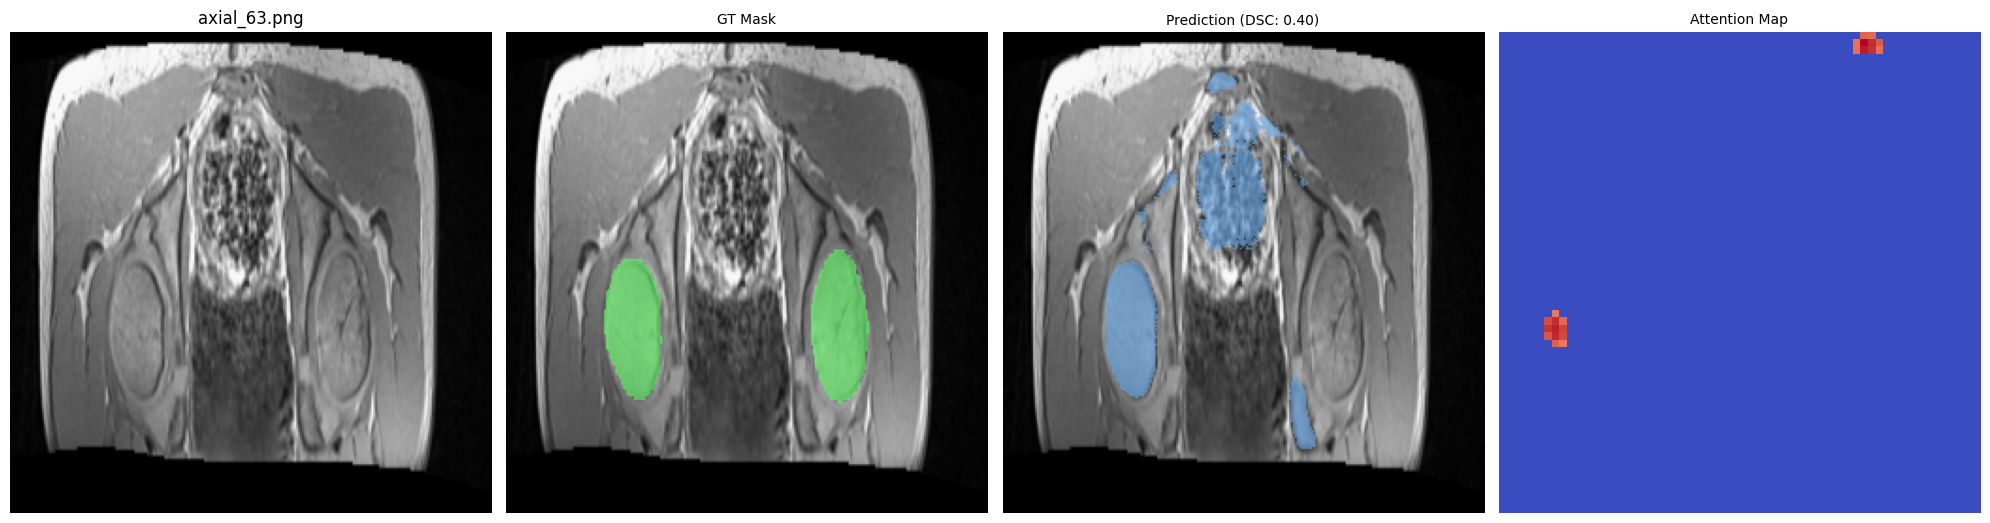

In [63]:
def evaluate_1_volume_withattentionbox(image_vol, model, device, slice_id=None, target_spacing=None, atten_map=None, selected_box=None):
    """
    Evaluate a single volume slice with optional attention map and selected points (prompts).
    """
    # Normalize volume data
    image_vol.data = image_vol.data / (image_vol.data.max() * 1.0)
    voxel_spacing = image_vol.spacing
    
    # Resample if target_spacing is provided
    if target_spacing and (voxel_spacing != target_spacing):
        resample = tio.Resample(target_spacing, image_interpolation='nearest')
        image_vol = resample(image_vol)
    
    # Get the slice
    image_vol = image_vol.data[0]
    slice_num = image_vol.shape[2]
    if slice_id is not None:
        if slice_id > slice_num:
            slice_id = -1
    else:
        slice_id = slice_num // 2
    
    # Convert slice data to [0, 255] range
    img_arr = image_vol[:, :, slice_id]
    img_arr = np.array((img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 0.00001) * 255, dtype=np.uint8)
    
    # Convert single channel to RGB
    img_3c = np.tile(img_arr[:, :, None], [1, 1, 3])
    img = Image.fromarray(img_3c, 'RGB')
    Pil_img = img.copy()
    img = transforms.Resize((1024, 1024))(img)
    
    # Transform and normalize
    transform_img = transforms.Compose([
        transforms.ToTensor()
    ])
    img = transform_img(img)
    img = min_max_normalize(img)
    if img.mean() < 0.1:
        img = monai.transforms.AdjustContrast(gamma=0.8)(img)
    
    imgs = torch.unsqueeze(
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img), 0
    ).to(device)

    # Forward pass with optional attention and selected points (prompts)
    with torch.no_grad():
        img_emb = model.image_encoder(imgs)

        if selected_box is not None:
            # boxes=selected_box, points=None
            sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=selected_box, masks=None)
        else:
            sparse_emb, dense_emb = model.prompt_encoder(points=None, boxes=None, masks=None)
        
        if atten_map is not None:
            img_emb = model.attention_fusion(img_emb, atten_map)
        
        pred, _ = model.mask_decoder(
            image_embeddings=img_emb,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_emb,
            dense_prompt_embeddings=dense_emb,
            multimask_output=True,
        )
        pred = pred[:, 1, :, :]
    ori_img = inverse_normalize(imgs.cpu()[0])
    
    return ori_img, pred, voxel_spacing, Pil_img, slice_id


def evaluateSlicePrediction(mask_pred, mask_name, slice_id):
    """
    Compute Dice Coefficient (DSC) between prediction and ground truth mask.
    """
    mask_path = os.path.join(gt_msk_folder, f"{mask_name}_{slice_id}.png")
    msk = Image.open(mask_path)
    msk = transforms.Resize((256, 256))(msk)

    if msk.mode != 'L':
        msk = msk.convert('L')
    msk_gt = (transforms.ToTensor()(msk) > 0).float()
    
    dsc_gt = dice_coeff(mask_pred.cpu(), msk_gt).item()
    print("dsc_gt:", dsc_gt)
    return msk_gt, dsc_gt


def predictSlice(image_name, lower_percentile, upper_percentile, slice_id, attention_enabled, selected_box=None):
    """
    Predict the mask for a single slice, optionally using an attention map and/or selected points (prompts).
    """
    img_path = os.path.join(img_folder, f"{image_name}_{slice_id}.png")
    image = Image.open(img_path)
    if image.mode != 'L':
        image = image.convert('L')
    
    # Convert image to tensor
    image_tensor = transforms.ToTensor()(image)
    
    # Adjust dimensions to [1, 1, H, W, 1]
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.unsqueeze(-1)
    
    # Data normalization
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    
    # Remove batch dimension -> (1, x, y, z)
    image_tensor = image_tensor.squeeze(0)
    image1_vol = tio.ScalarImage(tensor=image_tensor)
    
    # Generate attention map
    atten_map = pred_attention(image1_vol, vnet, 0, device)
    atten_map = torch.unsqueeze(torch.tensor(atten_map), 0).float().to(device)

    # Evaluate using attention map or just points
    if attention_enabled:
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionbox(
            image1_vol, sam_fine_tune, device, slice_id=0, atten_map=atten_map, selected_box=selected_box
        )
    else:
        # No attention map
        ori_img, pred_1, _, Pil_img1, _ = evaluate_1_volume_withattentionbox(
            image1_vol, sam_fine_tune, device, slice_id=0, selected_box=selected_box
        )
    
    mask_pred = ((pred_1 > 0) == cls).float().cpu()
    return ori_img, mask_pred, atten_map


def visualizeSlicePrediction(ori_img, image_name, atten_map, msk_gt, mask_pred, dsc_gt, selected_box=None):
    """
    Visualize original image, ground truth mask, predicted mask, and attention map.
    Optionally, display selected points on the image.
    """
    image = torchvision.transforms.Resize((args.out_size, args.out_size))(ori_img)[0]
    image_3d = np.repeat((image * 255).numpy().astype(np.uint8)[:, :, np.newaxis], 3, axis=2)
    
    pred_mask_auto = (mask_pred[0]) * 255
    mask = (msk_gt.cpu()[0] > 0) * 255
    
    target_prediction = [103, 169, 237]
    image_pred_auto = drawContour(image_3d.copy(), pred_mask_auto, target_prediction, size=-1, a=0.6)
    
    target_prediction = [100, 255, 106]
    image_mask = drawContour(image_3d.copy(), mask, target_prediction, size=-1, a=0.6)
    
    # If bounding box is provided, draw it
    if selected_box is not None:
        # Suppose shape is (1, 4) or (B, 4)
        box_np = selected_box.cpu().numpy() if torch.is_tensor(selected_box) else np.array(selected_box)
        box_np = box_np.reshape(-1, 4)  # ensure shape [N, 4]

        for (x1, y1, x2, y2) in box_np:
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            cv2.rectangle(image_3d, (x1, y1), (x2, y2), color=(255,0,0), thickness=2)

    
    fig, a = plt.subplots(1, 4, figsize=(20, 15))
    a[0].imshow(image, cmap='gray', vmin=0, vmax=1)
    a[0].set_title(image_name)
    a[0].axis(False)
    
    a[1].imshow(image_mask, cmap='gray', vmin=0, vmax=255)
    a[1].set_title('GT Mask', fontsize=10)
    a[1].axis(False)
    
    a[2].imshow(image_pred_auto, cmap='gray', vmin=0, vmax=255)
    a[2].set_title('Prediction (DSC: %.2f)' % dsc_gt, fontsize=10)
    a[2].axis(False)
    
    a[3].imshow(atten_map.cpu()[0], vmin=0, vmax=1, cmap='coolwarm')
    a[3].set_title('Attention Map', fontsize=10)
    a[3].axis(False)
    
    plt.tight_layout()


selected_box = torch.tensor([[68, 71, 123, 126], [213, 66, 277, 131]], dtype=torch.float32)

# Predict slice
ori_img, predictedSliceMask, atten_map = predictSlice(
    image_name='axial',
    lower_percentile=1,
    upper_percentile=99,
    slice_id=63,
    attention_enabled=True,
    selected_box=selected_box
)

# Evaluate prediction
msk_gt, dsc_gt = evaluateSlicePrediction(
    mask_pred=predictedSliceMask,
    mask_name='axial',
    slice_id=63
)

# Visualize
box = [[68, 71, 123, 126], [213, 66, 277, 131]]
visualizeSlicePrediction(
    ori_img=ori_img,
    image_name='axial_63.png',
    atten_map=atten_map,
    msk_gt=msk_gt,
    mask_pred=predictedSliceMask,
    dsc_gt=dsc_gt,
    selected_box=box
)


## 3D Volume Prediction & Evaluation

In [77]:
def predictVolume(image_name, lower_percentile, upper_percentile):
    dsc_gt = 0
    image1_vol = tio.ScalarImage(os.path.join(img_folder,image_name))
    print('vol shape: %s vol spacing %s' %(image1_vol.shape,image1_vol.spacing))

    # Define the percentiles
    image_tensor = image1_vol.data
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)

    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    # Normalize the data to [0, 1] 
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    image1_vol.set_data(image_tensor)
    
    mask_vol_numpy = np.zeros(image1_vol.shape)
    id_list = list(range(image1_vol.shape[3]))
    for id in id_list:
        atten_map = pred_attention(image1_vol,vnet,id,device)
        atten_map = torch.unsqueeze(torch.tensor(atten_map),0).float().to(device)
        
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=id,atten_map=atten_map)
        img1_size = Pil_img1.size
        mask_pred = ((pred_1>0)==cls).float().cpu()
        pil_mask1 = Image.fromarray(np.array(mask_pred[0],dtype=np.uint8),'L').resize(img1_size,resample= PIL.Image.NEAREST)
        mask_vol_numpy[0,:,:,id] = np.asarray(pil_mask1)
    
    mask_vol = tio.LabelMap(tensor=torch.tensor(mask_vol_numpy,dtype=torch.int), affine=image1_vol.affine)
    mask_save_folder = os.path.join(predicted_msk_folder,'/'.join(image_name.split('/')[:-1]))
    Path(mask_save_folder).mkdir(parents=True, exist_ok = True)
    mask_vol.save(os.path.join(mask_save_folder,image_name.split('/')[-1].replace('.nii.gz','_predicted_SAMatten_paired.nrrd')))
    return mask_vol

In [78]:
def predictAndEvaluateVolume(image_name, mask_name, lower_percentile, upper_percentile):
    dsc_gt = 0
    image1_vol = tio.ScalarImage(os.path.join(img_folder,image_name))
    print('vol shape: %s vol spacing %s' %(image1_vol.shape,image1_vol.spacing))

    # Define the percentiles
    image_tensor = image1_vol.data
    lower_bound = torch_percentile(image_tensor, lower_percentile)
    upper_bound = torch_percentile(image_tensor, upper_percentile)

    # Clip the data
    image_tensor = torch.clamp(image_tensor, lower_bound, upper_bound)
    # Normalize the data to [0, 1] 
    image_tensor = (image_tensor - lower_bound) / (upper_bound - lower_bound)
    image1_vol.set_data(image_tensor)
    
    voxels, header = nrrd.read(os.path.join(gt_msk_folder,mask_name))
    mask_gt = voxels
    mask_vol_numpy = np.zeros(image1_vol.shape)
    id_list = list(range(image1_vol.shape[3]))
    for id in id_list:
        atten_map = pred_attention(image1_vol,vnet,id,device)
        atten_map = torch.unsqueeze(torch.tensor(atten_map),0).float().to(device)
        
        ori_img,pred_1,voxel_spacing1,Pil_img1,slice_id1 = evaluate_1_volume_withattention(image1_vol,sam_fine_tune,device,slice_id=id,atten_map=atten_map)
        img1_size = Pil_img1.size

        mask_pred = ((pred_1>0)==cls).float().cpu()
        msk = Image.fromarray(mask_gt[:,:,id].astype(np.uint8), 'L')
        msk = transforms.Resize((256,256))(msk)
        msk_gt = (transforms.ToTensor()(msk)>0).float().cpu()
        dsc_gt += dice_coeff(mask_pred.cpu(),msk_gt).item()
        pil_mask1 = Image.fromarray(np.array(mask_pred[0],dtype=np.uint8),'L').resize(img1_size,resample= PIL.Image.NEAREST)
        mask_vol_numpy[0,:,:,id] = np.asarray(pil_mask1)
    
    mask_vol = tio.LabelMap(tensor=torch.tensor(mask_vol_numpy,dtype=torch.int), affine=image1_vol.affine)
    mask_save_folder = os.path.join(predicted_msk_folder,'/'.join(image_name.split('/')[:-1]))
    Path(mask_save_folder).mkdir(parents=True,exist_ok = True)
    mask_vol.save(os.path.join(mask_save_folder,image_name.split('/')[-1].replace('.nii.gz','_predicted_SAMatten_paired.nrrd')))
    dsc_gt /= len(id_list)
    gt_vol = tio.LabelMap(tensor=torch.unsqueeze(torch.Tensor(mask_gt>0),0), affine=image1_vol.affine)
    dsc_vol = dice_coeff(mask_vol.data.float().cpu(),gt_vol.data).item()
    print('volume %s: slice_wise_dsc %.2f; vol_wise_dsc %.2f'%(image_name,dsc_gt,dsc_vol))

In [ ]:
mask = predictVolume(
    image_name = '2.nii.gz', 
    lower_percentile = 1, 
    upper_percentile = 99
)

In [ ]:
predictAndEvaluateVolume(
    image_name = '2.nii.gz', 
    mask_name = '2.nrrd',
    lower_percentile = 1, 
    upper_percentile = 99
)